## Movielens

In [53]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
!pwd

/mnt/projects/lrajlich/fastai/courses/dl1


In [3]:
path='data/ml-latest-small/'
!ls {path}

links.csv	     models		     ratings.csv  tmp
ml-latest-small      movies.csv		     README.txt
ml-latest-small.zip  ratings_classifier.csv  tags.csv


We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [5]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [16]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


### Collaborative filtering *Classifier*


In [13]:
### BELOW IS THE NOTEBOOK CODE TO RUN CollabFilterClassifier

In [5]:
## Modify the data set for to be 1 (recommend) or 0 (not recommend)

# Create a recommend column that evaluates to 1 for ratings of 4 and above
ratings['recommend'] = (ratings['rating'] >= 4) * 1
print(ratings.head())

# Write to another csv... because
ratings.to_csv(path+'ratings_classifier.csv')



   userId  movieId  rating   timestamp  recommend
0       1       31     2.5  1260759144          0
1       1     1029     3.0  1260759179          0
2       1     1061     3.0  1260759182          0
3       1     1129     2.0  1260759185          0
4       1     1172     4.0  1260759205          1


In [6]:
# Validate that the csv can be read
ratings_classifier = pd.read_csv(path+'ratings_classifier.csv')
ratings_classifier.head()
ratings_classifier.shape

(100004, 6)

In [7]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [49]:
cf_classifier = CollabFilterDataset.from_csv(path, 'ratings_classifier.csv', 'userId', 'movieId', 'recommend')

In [30]:
F.binary_cross_entropy
input = V(torch.randn(3, 5), requires_grad=True)
target = V(torch.LongTensor(3).random_(5))
loss = F.cross_entropy(input, target)
loss.backward()
print(input)
print(target)
print(loss)

Variable containing:
 1.1957  1.4241 -0.0097  0.2983 -0.0552
 0.6456 -0.6291 -1.0778  0.7601 -0.0596
 1.6624 -0.4112  1.5942 -0.0896  0.6369
[torch.cuda.FloatTensor of size 3x5 (GPU 0)]

Variable containing:
 4
 2
 0
[torch.cuda.LongTensor of size 3 (GPU 0)]

Variable containing:
 2.0760
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [52]:
input = V(torch.randn(3), requires_grad=True)
target = V(torch.FloatTensor(3).random_(2))
print(input)
print(F.sigmoid(input))
print(target)
loss = F.binary_cross_entropy(F.sigmoid(input), target)
loss.backward()
print(loss)

Variable containing:
 1.3910
 1.4485
 1.2475
[torch.cuda.FloatTensor of size 3 (GPU 0)]

Variable containing:
 0.8007
 0.8098
 0.7769
[torch.cuda.FloatTensor of size 3 (GPU 0)]

Variable containing:
 0
 1
 0
[torch.cuda.FloatTensor of size 3 (GPU 0)]

Variable containing:
 1.1081
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [54]:
learn_classifier = cf_classifier.get_learner(50, val_idxs, 64, opt_fn=optim.Adam, is_reg=False)

In [55]:
learn_classifier.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.59769  0.60126]                                    
[ 1.       0.58599  0.58989]                                    
[ 2.       0.59227  0.58932]                                    



In [56]:
preds = learn_classifier.predict()

In [57]:
print(learn_classifier.data.val_y[:10,])
print(preds[:10])

[ 0.  1.  0.  0.  1.  1.  0.  0.  1.  1.]
[ 0.40012  0.62867  0.4431   0.54735  0.44343  0.43822  0.40851  0.49985  0.56648  0.57583]


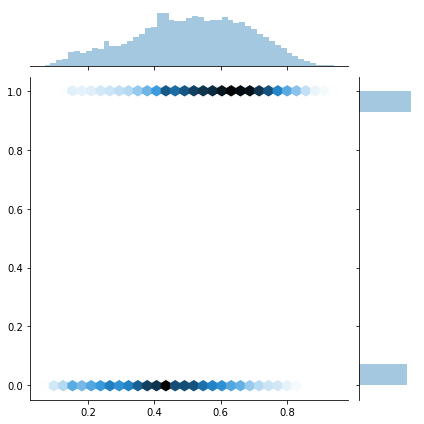

In [58]:
sns.jointplot(preds, learn_classifier.data.val_y, kind='hex', stat_func=None);

In [ ]:
### END OF THE NOTEBOOK CODE TO RUN CollabFilterClassifier

### Dot product example

In [8]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.FloatTensor of size 2x2], 
   2   2
  10  10
 [torch.FloatTensor of size 2x2])

In [9]:
a*b


  2   4
 30  40
[torch.FloatTensor of size 2x2]

In [10]:
(a*b).sum(1)


  6
 70
[torch.FloatTensor of size 2]

In [16]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [17]:
model=DotProduct()

In [18]:
model(a,b)


  6
 70
[torch.FloatTensor of size 2]

### Dot product model

In [11]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [12]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [13]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating']

In [14]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [12]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [12]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.71202  1.62544]                                   
[ 1.       1.14607  1.30154]                                   
[ 2.       0.90666  1.21723]                                    



In [13]:
set_lrs(opt, 0.01)

In [14]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.69763  1.14979]                                    
[ 1.       0.70115  1.13657]                                    
[ 2.       0.66739  1.1303 ]                                    



### Bias

In [13]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [14]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [15]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [16]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.82933  0.8363 ]                                    
[ 1.       0.82111  0.81762]                                    
[ 2.       0.77819  0.81243]                                    



In [17]:
set_lrs(opt, 1e-2)

In [18]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.73096  0.80464]                                    
[ 1.       0.73178  0.80268]                                    
[ 2.       0.72838  0.8019 ]                                    



### Mini net

In [19]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.75, p2=0.75):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = F.dropout(torch.cat([self.u(users),self.m(movies)], dim=1), p1)
        x = F.dropout(F.relu(self.lin1(x)), p2)
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [24]:
wd=5e-4
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-2, weight_decay=wd, momentum=0.9)

In [25]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.90059  0.88923]                                    
[ 1.       0.83325  0.85756]                                    
[ 2.       0.84119  0.81259]                                    



In [26]:
set_lrs(opt, 1e-3)

In [27]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.71088  0.79029]                                    
[ 1.       0.69958  0.78893]                                    
[ 2.       0.67735  0.78804]                                    

